In [171]:
import numpy as np
import scipy

from scipy import signal
from scipy.signal import find_peaks, convolve
from scipy.signal import welch


import matplotlib.pyplot as plt
%matplotlib inline


data = np.load("data.npy")
data = np.transpose(data, (0, 2, 1))
labels  = np.load("labels.npy")
print(labels)
emotion_keys = ["No Emotion", "Anger", "Hate", "Grief","P-Love", "R-Love","Joy", "Reverence"]
labels_number = np.ndarray((160))
for i,key in enumerate(emotion_keys):
    labels_number[np.where(labels == key)] = i
print(labels_number)
HR = np.load('HR_2001.npy', allow_pickle = True)
print(HR.shape)

['No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion'
 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion'
 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion'
 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'No Emotion' 'Anger'
 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger'
 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger' 'Anger'
 'Anger' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate'
 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate' 'Hate'
 'Hate' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief'
 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief' 'Grief'
 'Grief' 'Grief' 'Grief' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love'
 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love'
 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'P-Love' 'R-Love'
 'R-Love' 'R-Love' 'R-Love' 'R-Love' 'R-Love' 'R-Love' 'R-Love' 'R-Love'
 'R-L

In [172]:
GSR = data[:, 2,:]
BVP = data[:, 1, :]
EMG = data[:, 0, :]
RES = data[:, 3,:]
print(GSR.shape)

def difference_absolute_values_mean(signal, different_num, round_number = 2, round_ = False):
    value = 0
    for i in range(len(signal) - different_num):
        value += abs(signal[i+different_num] - signal[i])
    if round_:        
        mean_value = np.round_(value/(len(signal) - different_num), round_number )
    else:
        mean_value = value/(len(signal) - different_num)

    return mean_value

(160, 2001)


In [204]:
def get_smooth(data, plot = False):
    d_list = [] 
    lc = int(len(data[0])/4) # get len of hanning window = 1/4 * len(original_signal) 
    print("len of hanning window: ", lc) 
    for i in range(data.shape[0]):
        d = convolve(np.hanning(lc)/np.hanning(lc).sum(), data[i].reshape(data[i].shape[0]), mode = "valid" )
        d_list.append(d)
    
    if plot:
        print(np.array(d_list).shape)
        for i in range(5):
            fig, ax = plt.subplots(2,1,figsize = (10,6))
            ax[1].plot(d_list[i])
            ax[0].plot(data[i])
            plt.plot()
        
    return d_list

def get_f1_f2(HR):
    HR_smooth = get_smooth(HR, plot = False)
    f1 = [] # mean HR
    f2 = [] # mean of first difference
    for signal in HR:
        f1.append(np.mean(signal))
        f2.append(difference_absolute_values_mean(signal, 1))
    return f1, f2

def normalize_GSR(GSR_signal_list):
    normalized_smooth_list = []
    minG = [] # max value of the days
    maxG = [] # min value of the days
    for i in range(0,160,8): # for each day
        minG.append(np.min(GSR_signal_list[i:i+8]))
        maxG.append(np.max(GSR_signal_list[i:i+8]))
    print("minG: ",np.array(minG).shape)
    print("maxG: ",np.array(maxG).shape)
    
    for j, i in enumerate(range(0, 160, 8)): 
        for signal in GSR_signal_list[i:i+8]:
            normalized_signal = (signal - minG[j])/(maxG[j] - minG[j] + np.finfo(float).eps) # avoiding divided by zero
            normalized_smooth_list.append(normalized_signal)
    return normalized_smooth_list

def get_f3_f4(GSR):
    return get_f1_f2(GSR)

def calculate_r(list_RES):
    l = np.array(list_RES).shape[0]
    r_normalized = [] # normalized RES
    uR = [] # mean vector of the days
    for i in range(0, 160, 8):
        s = np.mean(list_RES[i:i+8], axis = 0)
        uR.append(s)
    
    for j, i in enumerate(range(0, 160, 8)):
        for signal in list_RES[i:i+8]:
            signal = signal-uR[j]
            r_normalized.append(signal)
    return np.array(r_normalized), np.array(uR)

def get_f5_f6(RES):
    f5 = []
    f6 = []
    r_normalized, uR = calculate_r(RES)
    for signal in r_normalized:
        f5.append(np.mean(signal))
        f6.append(np.var(signal, ddof=1)) ## ddof = 1 -> dividing by (N-1)
    return f5, f6

def get_psd_values(y_values, f_s = 20):
    nfft = 2**(int(np.log2(len(y_values)))+1) # nfft = min(2^n) : 2^n > len(y_values), n = 1, 2, 3 ...
#     print(nfft)
    f_values, psd_values = welch(y_values, fs=f_s, nfft=nfft)
    return f_values, psd_values

def get_f7_f10(RES):
    r_normalized, uR = calculate_r(RES)

    f7 = []
    f8 = []
    f9 = []
    f10 = []
    for r in r_normalized:
        _, psd_values = get_psd_values(r)

        normalized_psd_values = psd_values/np.sum(psd_values, axis = 0)
        normalized_psd_values = normalized_psd_values[:1000].reshape(-1, 10) # take only 1000 first and reshape (, 10)
        sum_psd = np.sum(normalized_psd_values, axis = 1) # calculate sum of each 10-length vector 
        # take only 4 first value according to 0.0-0.1, 0.1-0.2, 0.2-0.3, 0.3-0.4 (Hz)
        f7.append(sum_psd[0])
        f8.append(sum_psd[1])
        f9.append(sum_psd[2])
        f10.append(sum_psd[3])
    return f7, f8, f9, f10

In [210]:
f1, f2  = get_f1_f2(HR)
f3, f4 = get_f3_f4(GSR)
f5, f6 = get_f5_f6(RES)
f7, f8, f9, f10 = get_f7_f10(RES)

len of hanning window:  500
len of hanning window:  500


len of hanning window:  500
(160, 1502)
len of hanning window:  500
(160,)


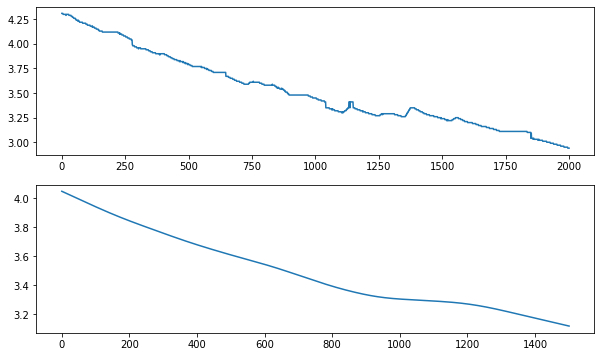

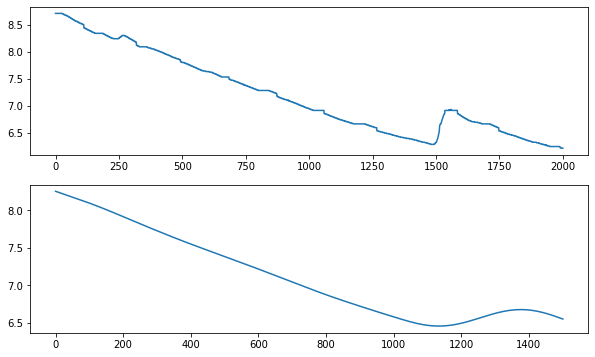

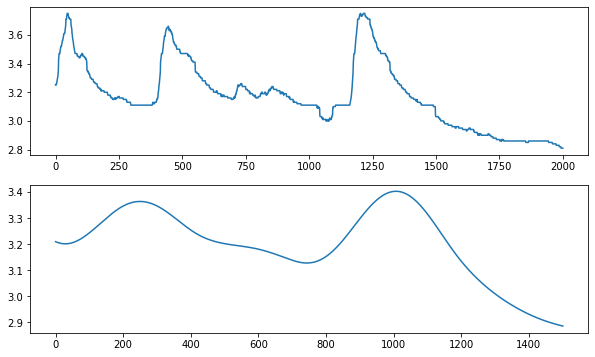

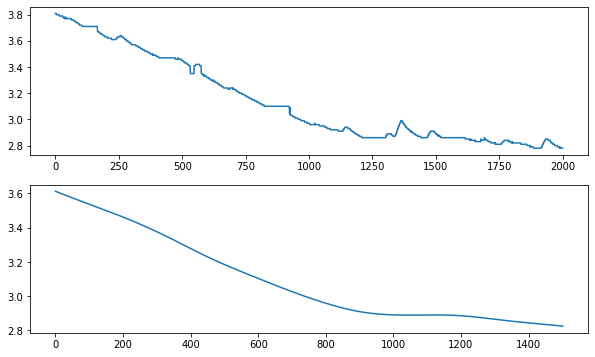

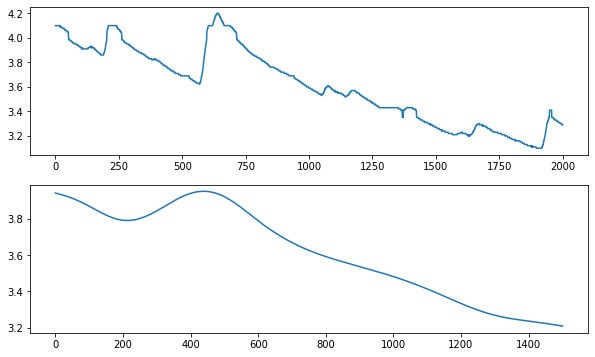

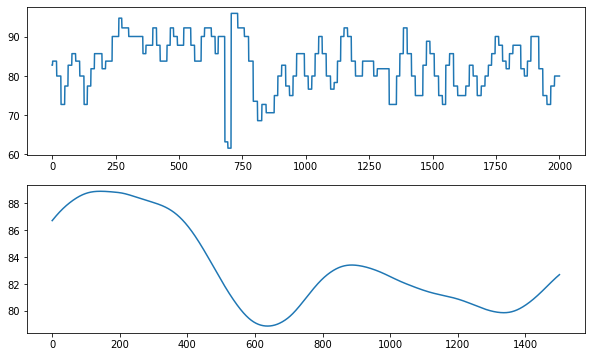

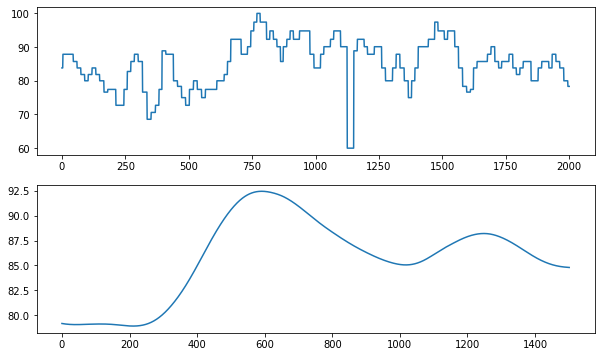

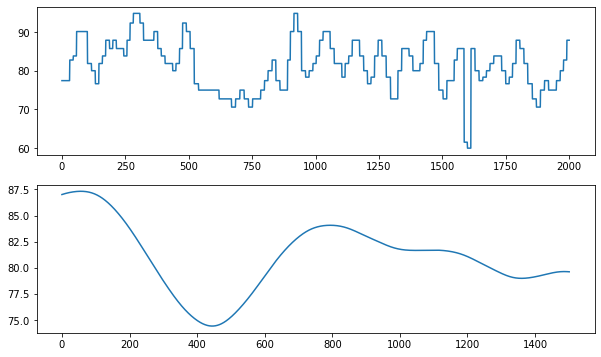

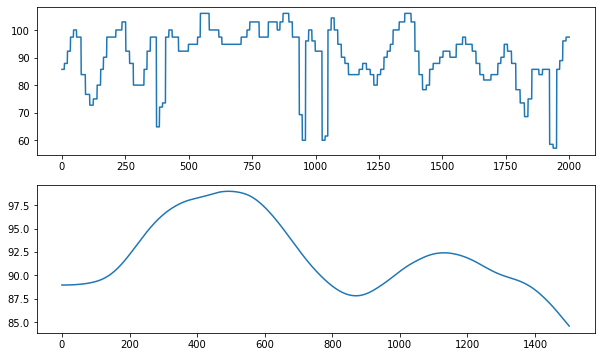

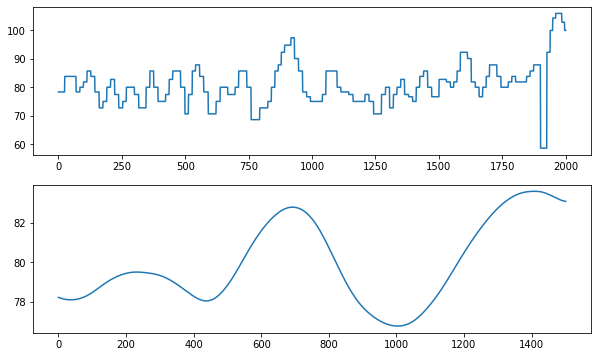

In [211]:
GSR_smooth = get_smooth(GSRx, plot = True)
HR_smooth = get_smooth(HR, plot = True)